In [1]:
import os
from glob import glob

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip

import tqdm

In [2]:
# Class holding the entire advanced lane finding pipeline,
# including camera calibration, image undistortion,
# thresholding, perspective warping, curvature calculation,
# lane coloring and lane center displacement reporting.
class LanePipeline:
    # Constructor takes images for camera calibration,
    # as well as perspective warping coefficients.
    def __init__(
        self,
        camera_calibr_images,
        perspective_src,
        perspective_dst
    ):
        print("Calibrating camera. Please wait...")
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = \
            self._calibrate_camera(camera_calibr_images)
        print("Camera calibration complete.")
        
        # Get perspective transform since we'll have to warp every image.
        # Also store the inverse transform to re-project the lane onto
        # the original image.
        self.perspective_src = perspective_src
        self.perspective_dst = perspective_dst
        self.M = cv2.getPerspectiveTransform(self.perspective_src, self.perspective_dst)
        self.Minv = cv2.getPerspectiveTransform(self.perspective_dst, self.perspective_src)
        
        # Average points for lane finding over thi many frames.
        # Could be a constructor parameter as well, rather
        # than a hard-coded number.
        self.num_frames_to_average = 30
        
        # Store x and y points corresponding to what we think are the lanes
        # as a field in the LanePipeling object - we'll need past points
        # to fit lane curves over the past few images (specified by 
        # self.num_frames_to_average above), not just the current one.
        self.left_x_points = []
        self.left_y_points = []
        self.right_x_points = []
        self.right_y_points = []

    def _calibrate_camera(self, files):
        
        # Create grid for object points. They will be the same for all images.
        # Only image points will change
        objp = np.zeros((6 * 9, 3), np.float32)
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
        
        object_points = []
        image_points = []
        
        # Use tqdm to show progress bar. This can take a while.
        for fname in tqdm.tqdm(files):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find chessboard corners for the current image.
            # See here: http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            if ret:
                # If valid corners identified, add object points (always
                # the same) and image points (image-dependent).
                object_points.append(objp)
                image_points.append(corners)           
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
        # Return camera matrix, distortion coefficients, etc.
        return ret, mtx, dist, rvecs, tvecs
    
    # Convenience method since we should just provide the image and
    # not have to keep providing the camera matrix - it will be accessed
    # via a field of this class.
    def camera_undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    # Threshold an image based on the Sobel operator.
    # See more here: https://en.wikipedia.org/wiki/Sobel_operator
    # Can apply the horizontal or vertical operator.
    # Accepts minimum and maximum gradient when thresholding the image.
    @staticmethod
    def abs_sobel_thresh(img, orient='x', thresh=(0, 255), ksize=3):
        thresh_min, thresh_max = thresh
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # Return the result
        return binary_output    
    
    # Threshold an image based on the magnitude of the gradient, considering
    # the x and y directions. This requires that we take the square root of the
    # squared magnitudes of the x and y gradients, i.e. the Euclidean norm
    # of the (x, y) gradient vector.
    @staticmethod
    def sobel_mag_thresh(img, ksize=3, mag_thresh=(0, 255)):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        # Return the binary image
        return binary_output    
    
    @staticmethod
    # Threshold an image based on the direction of the gradient.
    def dir_threshold(img, ksize=3, thresh=(0, np.pi/2)):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
        # The direction of the gradient is simply the inverse tangent 
        # (arctangent) of the y gradient divided by the x gradient.
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        # Return the binary image
        return binary_output    
    
    # Combine the (x, y) gradient level thresholds, the (x, y)
    # magnitude threshold, the gradient direction threshold,
    # and the HLS colorspace thresholds (specifically, the
    # L and S thresholds)
    @staticmethod
    def combined_threshold(
        img,
        ksize=3, 
        dir_ksize=9,
        gradx_thresh=(20, 255),
        grady_thresh=(20, 255),
        mag_thresh=(30, 100),
        angle_thresh=(0.75*np.pi/2, np.pi/2),
        color_thresh=(40, 255)
    ):
        
        # Get grayscale image for Sobel operator-based
        # thresholding. Get an HLS image for L and S
        # channel-based thresholding
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        # We only need the L and S channels.
#        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        
        # Get points that pass the absolute Sobel operator
        # thresholds in the x and y directions.
        gradx = LanePipeline.abs_sobel_thresh(gray, orient='x', ksize=ksize, thresh=gradx_thresh)
        grady = LanePipeline.abs_sobel_thresh(gray, orient='y', ksize=ksize, thresh=grady_thresh)
       
        # We could be using the (x, y) gradient magnidue threshold
        # or the gradient direction threshold, but I didn't find
        # them to be helpful,given the values of the other thresholds.
#         mag_binary = LanePipeline.sobel_mag_thresh(gray, ksize=ksize, mag_thresh=mag_thresh)
#         dir_binary = LanePipeline.dir_threshold(gray, ksize=dir_ksize, thresh=angle_thresh)
        
    
        grads = np.zeros_like(gray)
        # populate with pixels that passed the x and y Sobel thresholds.
        grads[((gradx == 1) & (grady == 1))] = 1
        
        # Create saturation mask
        color_thresh1 = np.zeros_like(S)
        color_thresh1[(
                (S > color_thresh[0]) & (S <= color_thresh[1])
            )] = 1
        
        # Create another saturation and lightness mask
        color_thresh2 = np.zeros_like(S)
        color_thresh2[(
                (S > 70) & (S <= 255) & (L >= 50)
            )] = 1        
        
        combined = np.zeros_like(grads)
        # Combine gradient and color masks
        combined[(grads == 1) & (color_thresh1 == 1) | (color_thresh2 == 1)] = 1
        
        return combined
    
    def find_lines_histogram(self, img, visualize=False):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        if visualize:
            plt.plot(histogram)
            plt.title('Histogram')
            plt.show()
        out_img = np.dstack((img, img, img))*255 if visualize else None

        midpoint = np.int(histogram.shape[0]//2)
        self.leftx_base = np.argmax(histogram[:midpoint])
        self.rightx_base = np.argmax(histogram[midpoint:]) + midpoint
                
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = self.leftx_base
        rightx_current = self.rightx_base
        # Set the width of the windows +/- margin
        margin = 150
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
                
        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height     
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            if visualize:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # If we have pixels from enough frames to average,
        # pop the pixels from the oldest frame so we only
        # fit to the latest num_frames_to_average frames.
        
        if len(self.left_x_points) > self.num_frames_to_average:
            self.left_x_points.pop(0)
            
        if len(self.left_y_points) > self.num_frames_to_average:
            self.left_y_points.pop(0)
            
        if len(self.right_x_points) > self.num_frames_to_average:
            self.right_x_points.pop(0)
            
        if len(self.right_y_points) > self.num_frames_to_average:
            self.right_y_points.pop(0)            
        
        # If this is the first frame, we'll need to initialize
        if len(self.left_x_points) == 0:
            curr_leftx = leftx
            curr_lefty = lefty
            curr_rightx = rightx
            curr_righty = righty
        
        # Create flattened structure from points from the last few frames
        for i in range(len(self.left_x_points)):
            curr_leftx = np.concatenate(self.left_x_points)
            curr_lefty = np.concatenate(self.left_y_points)
            curr_rightx = np.concatenate(self.right_x_points)
            curr_righty = np.concatenate(self.right_y_points)
        
        # Store new points in the field
        self.left_x_points.append(leftx)
        self.left_y_points.append(lefty)
        self.right_x_points.append(rightx)
        self.right_y_points.append(righty)     
            
        # Fit a second order polynomial to each lane boundary (left and right)
        left_fit = np.polyfit(curr_lefty, curr_leftx, 2)
        right_fit = np.polyfit(curr_righty, curr_rightx, 2)               
            
        # curr_leftx, curr_rightx
        return leftx, rightx, left_fit, right_fit, nonzerox, \
            nonzeroy, left_lane_inds, right_lane_inds, out_img
    
    # Visualize the histogram that shows which "column" in the 
    # thresholded image has the most non-zero pixels.
    # This will help us find the lane lines.
    def visualize_hist(self, img, left_fit, right_fit, \
                       nonzerox, nonzeroy, left_lane_inds, \
                       right_lane_inds, out_img):
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Finding lane lines')
        plt.show()
        
    def curvature(self, img, left_fit, right_fit):
        
        #  meters per pixel in y dimension
        ym_per_pix = 30/720
        # meters per pixel in x dimension
        xm_per_pix = 3.7/700 
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

        leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        
        # Fit new polynomials to x,y in world space
        # (before we fit them in pixel space)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
        y_eval = np.max(ploty)
  
        # Calculate the new radii of curvature
        # Formula: R_curve = [(1 + (2Ay+B)^2)^(3/2)] / |2A|
        # See here: http://www.intmath.com/applications-differentiation/8-radius-curvature.php
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Center is the difference between lane center and the center of the image
        lane_center = ((rightx[-1] - leftx[-1]) / 2) + leftx[-1]
        lane_offset = np.abs(lane_center - 650)
        
        lane_offset_meters = lane_offset * xm_per_pix
        
        return left_curverad, right_curverad, lane_offset_meters
    
    # Draw the lane, then re-warp back into the original perspective.
    def draw_lane(self, img, warped, left_fit, right_fit, visualize=False):
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)        
        if visualize:
            plt.imshow(result)
            plt.title('Final Lane')
            plt.show()            
        return result
    
    # Apply the entire pipeline (image undistortion, thresholding,
    # warping, lane curve fitting, etc.). See individual methods
    # used here for comments about each of the steps.
    def pipeline_apply(self, original, visualize=False):        
        img_size = np.shape(original)        
        rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        if visualize:
            plt.imshow(rgb)
            plt.title('Original Image')
            plt.show()
        undist = self.camera_undistort(rgb)
        if visualize:
            plt.imshow(undist)
            plt.title('Corrected camera distortion')
            plt.show()
        thresholded = LanePipeline.combined_threshold(undist)
        if visualize:
            plt.imshow(thresholded, cmap='gray')
            plt.title('Thresholded image')
            plt.show()            
        warped = cv2.warpPerspective(thresholded, self.M, (img_size[1], img_size[0]))
        if visualize:
            plt.imshow(warped, cmap='gray')
            plt.title('Warped perspective')
            plt.show()
        leftx, rightx, left_fit, right_fit, nonzerox, nonzeroy, \
        left_lane_inds, right_lane_inds, out_img = self.find_lines_histogram(
            warped, visualize=visualize
        )
        if visualize:
            self.visualize_hist(
                warped, left_fit, right_fit,
                nonzerox, nonzeroy, left_lane_inds,
                right_lane_inds, out_img
            )
        left_curverad, right_curverad, lane_offset_m = self.curvature(warped, left_fit, right_fit)
        
        lane = self.draw_lane(undist, warped, left_fit, right_fit, visualize=visualize)
        
        text = "CURVE RADII: (%.2f m, %.2f m)" % (left_curverad, right_curverad)
        annotated = cv2.putText(lane, text, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 255, 155), 2, cv2.LINE_AA)
        text = "CENTER DISPLACEMENT: %.2f m" % lane_offset_m
        annotated = cv2.putText(annotated, text, (20, 160), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 255, 155), 2, cv2.LINE_AA)
        
        if visualize:
            plt.imshow(annotated)
            plt.title("annotated")
            plt.show()
            
        return rgb, undist, thresholded, warped, lane, annotated

    # Return image processed by the application of the pipeline
    def pipeline(self, img_path):
        rgb, undist, thresholded, warped, lane, annotated = self.pipeline_apply(img_path, False)
        annotated = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
        return annotated

In [3]:
src = np.float32([[555, 481], [734, 481], [299, 655], [1001, 655]])
dst = np.float32([[226, 96], [1106, 96], [246, 577], [1106, 577]])
           
pipeline = LanePipeline(
    camera_calibr_images = glob('./camera_cal/*.jpg'),
    perspective_src = src,
    perspective_dst = dst
)

  0%|          | 0/20 [00:00<?, ?it/s]

Calibrating camera. Please wait...


100%|██████████| 20/20 [00:06<00:00,  2.82it/s]


Camera calibration complete.


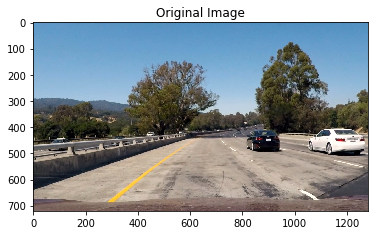

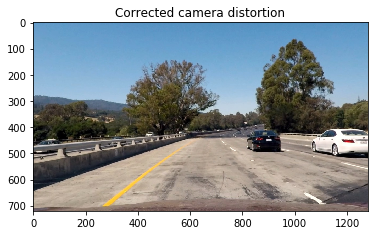

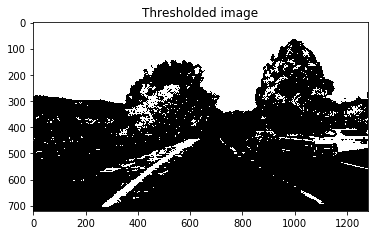

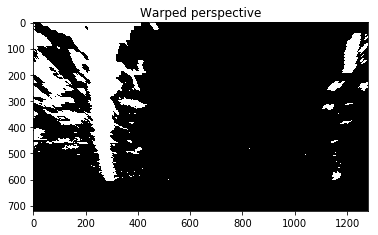

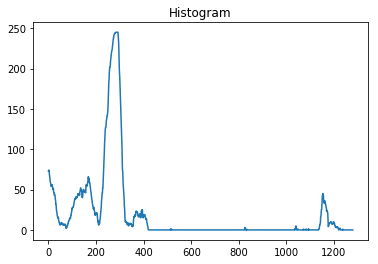

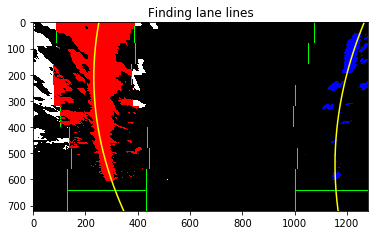

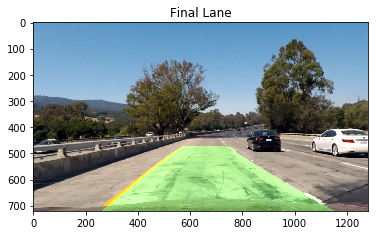

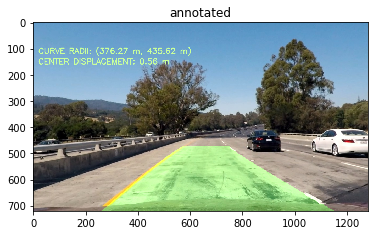

In [4]:
rgb, undist, thresholded, warped, lane, annotated = pipeline.pipeline_apply(
    cv2.imread('./test_images/test1.jpg'),
    visualize=True
)

In [5]:
def find_lines_in_video(video_path, pipeline):
    clip = VideoFileClip(video_path)
    clip_with_lines = clip.fl_image(pipeline.pipeline)
    clip_with_lines.write_videofile('annotated.mp4', audio=False)        

In [6]:
find_lines_in_video('./project_video.mp4', pipeline)

[MoviePy] >>>> Building video annotated.mp4
[MoviePy] Writing video annotated.mp4


100%|█████████▉| 1260/1261 [07:33<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated.mp4 

